<a href="https://www.kaggle.com/code/lorstann/akbank-dl-project?scriptVersionId=203135617" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

I am importing necessary libraries for this project.

In [85]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

I am getting the directories and their names as classes. Also, checking them.

In [86]:
directory = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

classes = [i for i in os.listdir(directory) if '.' not in i]
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

I get these codes from the Mr. Goker's notebook.

In [87]:
label = []
path = []

fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':     # If filename contains .png
            if dir_name.split()[-1] != 'GT':             # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1]) # Append the directory name to label
                path.append(os.path.join(dir_name, filename))  # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

In [88]:
data

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
...,...,...
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


In here, I try to visualize the classes and the number of data they contain.


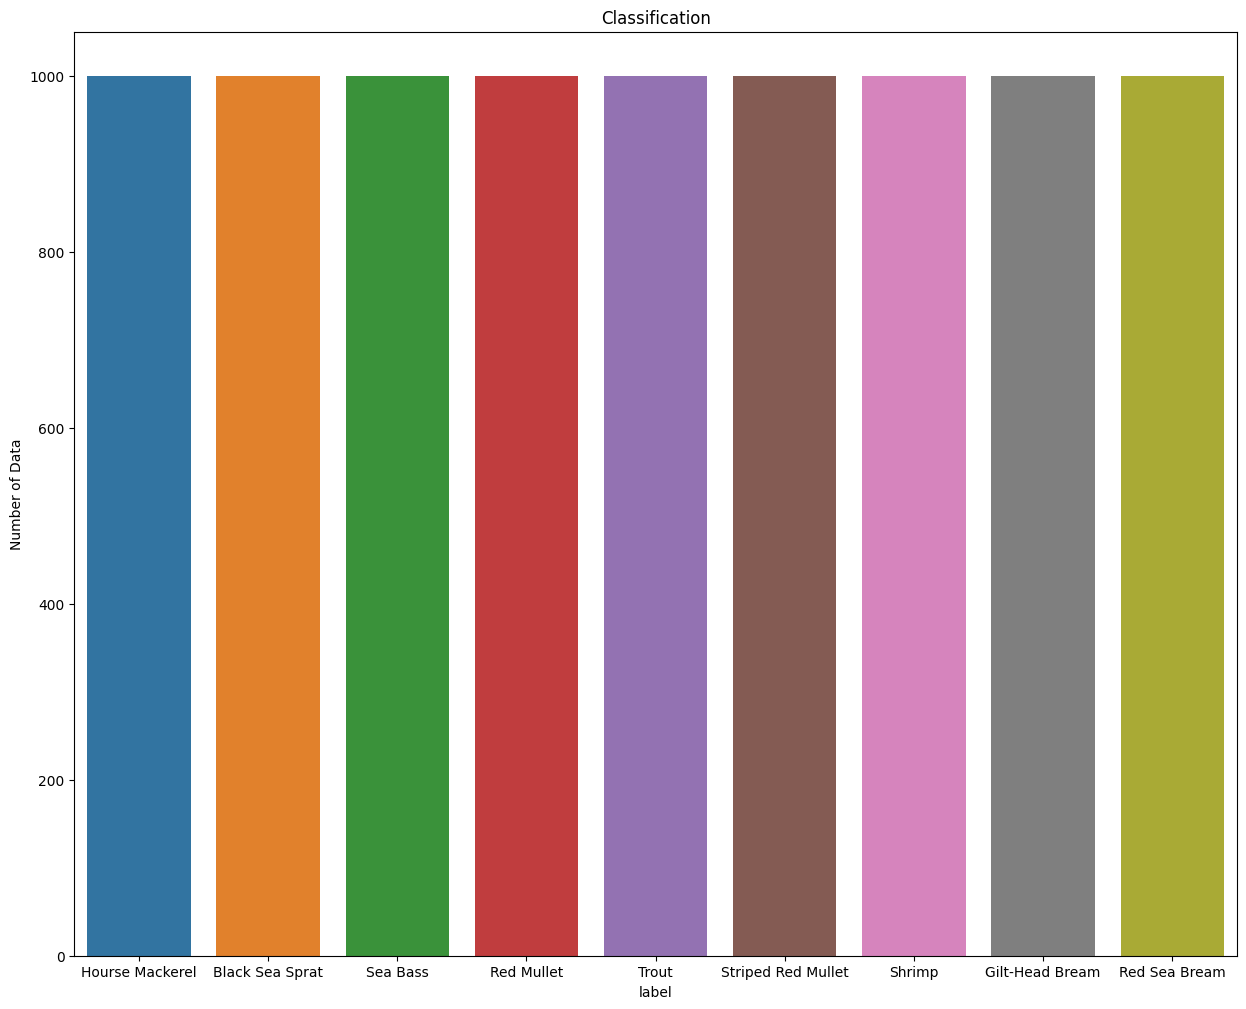

In [89]:
plt.figure(figsize=(15, 12))
sns.countplot(x='label', data=data)
plt.title('Classification')
plt.ylabel('Number of Data')
plt.show()

To visualize the a data for each classes. I choose 15x15 because of the square images. 

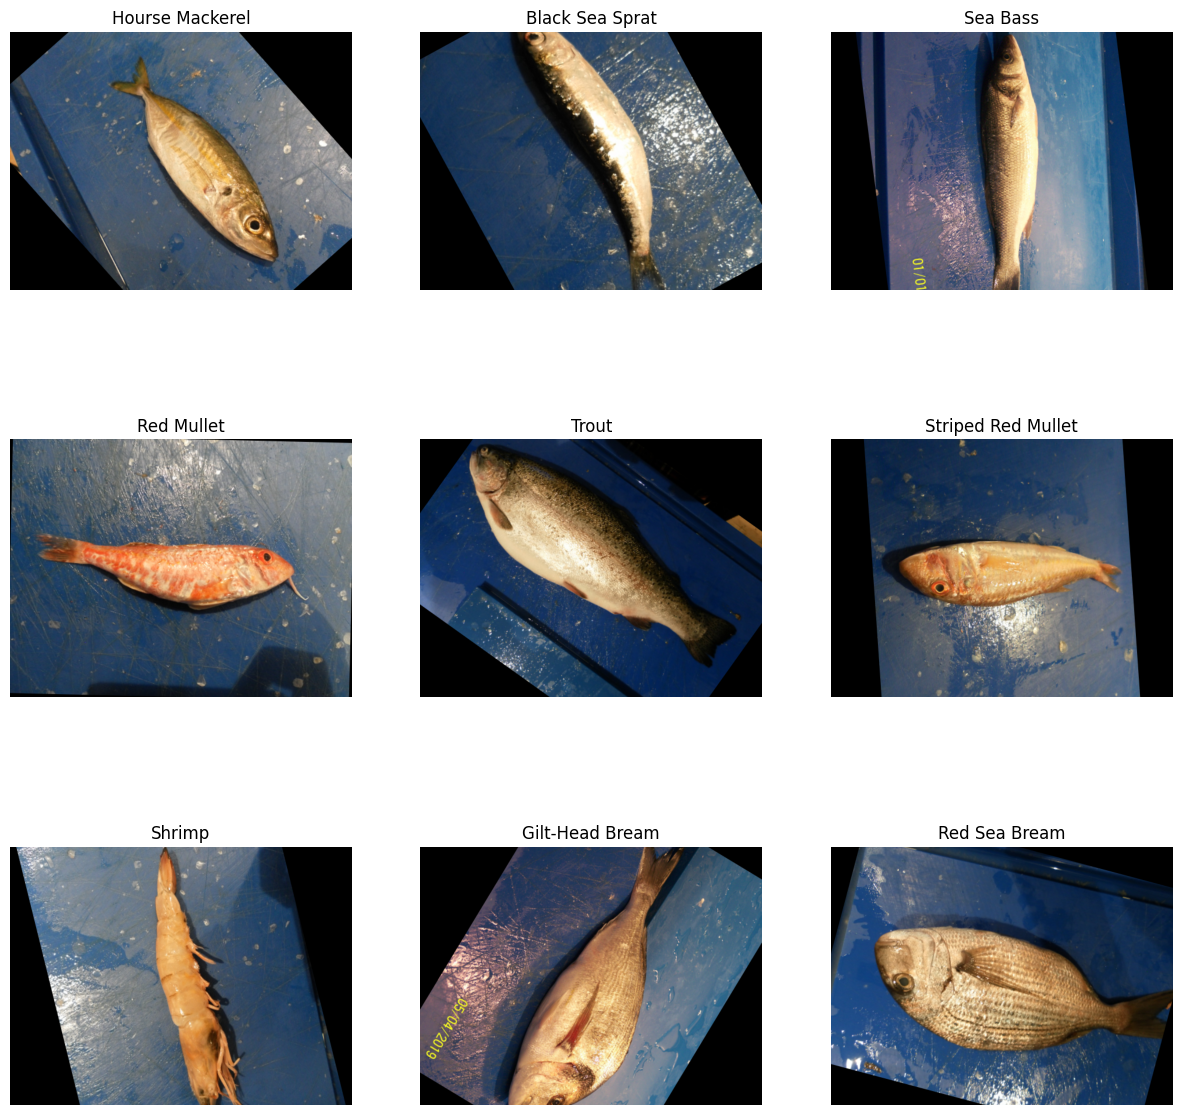

In [90]:
idx = 0
plt.figure(figsize=(15,15))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

I split the dataset to training and testing. I choose 80% for training and 20% for testing.

In [91]:
train_data, test_data = train_test_split(data, test_size= 0.2, shuffle= True, random_state= 42)

I am checking the data numbers and their shape for they are correct or not.

In [92]:
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (7200, 2)
Test data shape:  (1800, 2)


I am creating image data generators to preprocess the images for training, validation, and testing. For the training and validation sets, I use the ImageDataGenerator class with a rescaling factor of 1./255 to normalize the pixel values to the range [0, 1]. Additionally, I set a validation split of 0.2, which means 20% of the training data will be used for validation. 

In [93]:
train_generator = ImageDataGenerator(
    rescale= 1./255,
    validation_split= 0.2,
)

val_generator = ImageDataGenerator(
    rescale= 1./255,
    validation_split= 0.2
)

test_generator = ImageDataGenerator(rescale= 1./255)

First I tried with img size 28x28 but I cant say I get good result so I changed it 224x224 for the best training results. It causes more training time but I get better results. And also I tried batch size as 32 but again it gives me a bad accuracy so for the upgrading the accuracy I choose 64 for the batch size. We are working with real images so it needs to be rgb. We have 9 types of fish images so class mode needs to be categorical.

In [94]:
img_height= 224
img_width= 224
batch_size= 64

train_images = train_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col= 'path', 
    y_col= 'label', 
    target_size= (img_height, img_width), 
    color_mode= 'rgb', 
    class_mode= 'categorical', 
    batch_size= batch_size, 
    shuffle= True, 
    seed= 42, 
)
val_images = val_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col= 'path', 
    y_col= 'label', 
    target_size= (img_height, img_width), 
    color_mode= 'rgb', 
    class_mode= 'categorical', 
    batch_size= batch_size, 
    shuffle= True, 
    seed= 42, 
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data, 
    x_col= 'path', 
    y_col= 'label', 
    target_size= (img_height, img_width), 
    color_mode= 'rgb', 
    class_mode= 'categorical', 
    batch_size= batch_size, 
    shuffle= False 
)

Found 7200 validated image filenames belonging to 9 classes.
Found 7200 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [95]:
model = tf.keras.models.Sequential()

I defined Img size before the this block so I just call them again. 3 for the RGB.

Firstly, I tried 512-256-128-64 and after the every layers I put droput rate as 0.3. And it gets me realy bad train accuracy. I asked the global AI mentors and my university teacher, summary, they say me "You need more data for train or more layer.". So I upgraded the layer, put less dropout and reduced the rate of dropout. Finally, I got better results.

We are working with images so I choose relu. I have more than two classes so I choose softmax for the output layer.

In [96]:
model = Sequential()
model.add(Flatten(input_shape=(img_height, img_width, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

I am checking the my model.

In [97]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,839,561 (590.67 MB)

 Trainable params: 154,839,561 (590.67 MB)

 Non-trainable params: 0 (0.00 B)

Finally, I fitted. I choose 25 epoch because of the time. I tried too many times 100 epoch with early stopping but It causes really crucial long time. So, I analyze the all tries and I decide for the optimal number as 25.

In [98]:
results = model.fit(
    train_images, 
    epochs=25, 
    validation_data=val_images,
)

Epoch 1/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.1218 - loss: 11.8323 - val_accuracy: 0.1167 - val_loss: 2.1927
Epoch 2/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.1538 - loss: 2.1602 - val_accuracy: 0.1996 - val_loss: 1.9577
Epoch 3/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.2223 - loss: 1.9927 - val_accuracy: 0.3022 - val_loss: 1.7246
Epoch 4/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.2801 - loss: 1.8571 - val_accuracy: 0.4217 - val_loss: 1.6786
Epoch 5/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.3348 - loss: 1.7621 - val_accuracy: 0.3889 - val_loss: 1.5666
Epoch 6/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.3860 - loss: 1.6478 - val_accuracy: 0.4922 - val_loss: 1.3926
Epoch 7/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.4444 - loss: 1.5154 - val_accuracy: 0.5843 - val_loss: 1.2435
Epoch 8/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.4593 - loss: 1.4741 - val_acc

I get these code from Ms. Zeynep Güney's notebook. We visualized the our loss and accuracy as a graph.

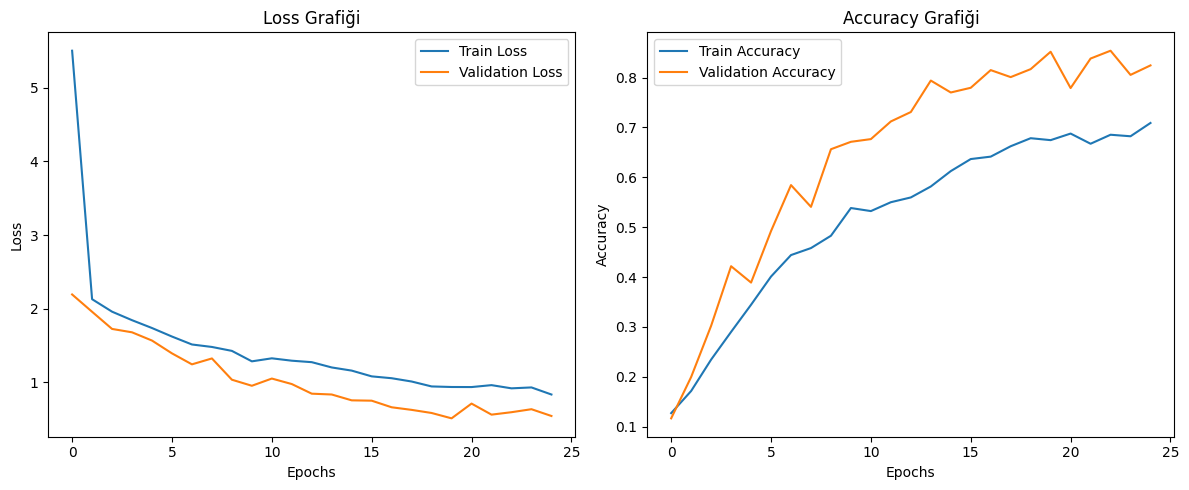

In [99]:
# Eğitim sonuçlarını görselleştirelim
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In here, our model is predicting.

In [100]:
pred = model.predict(test_images)
pred_classes = np.argmax(pred, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 664ms/step


Let's compare the predictions and validates.

In [101]:
test_loss, test_accuracy = model.evaluate(test_images)

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 676ms/step - accuracy: 0.7736 - loss: 0.6896


Our confusion matrix.

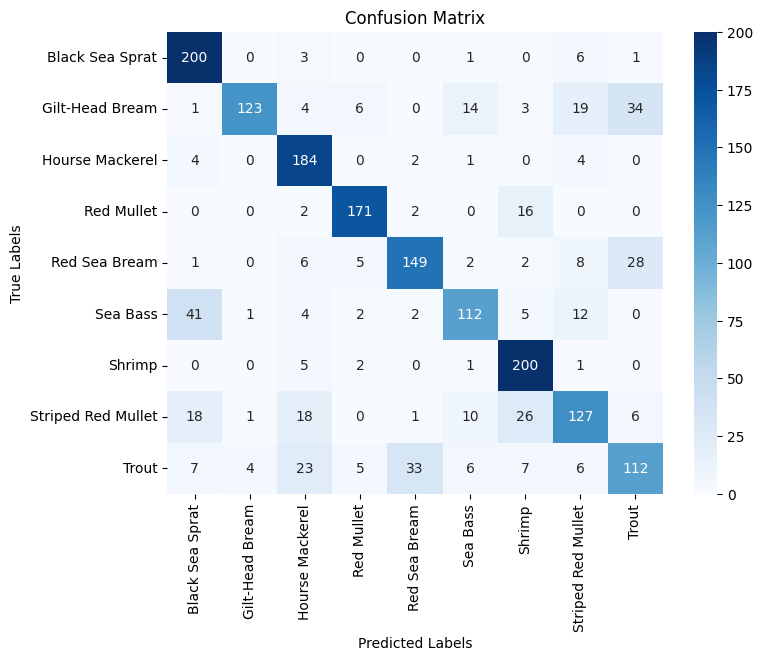

In [102]:
true_classes = test_images.classes
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Sınıf etiketlerini alın
class_labels = list(test_images.class_indices.keys())

# Konfüzyon matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [103]:
print(classification_report(true_classes, pred_classes, target_names=class_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.74      0.95      0.83       211
   Gilt-Head Bream       0.95      0.60      0.74       204
   Hourse Mackerel       0.74      0.94      0.83       195
        Red Mullet       0.90      0.90      0.90       191
     Red Sea Bream       0.79      0.74      0.76       201
          Sea Bass       0.76      0.63      0.69       179
            Shrimp       0.77      0.96      0.85       209
Striped Red Mullet       0.69      0.61      0.65       207
             Trout       0.62      0.55      0.58       203

          accuracy                           0.77      1800
         macro avg       0.77      0.76      0.76      1800
      weighted avg       0.77      0.77      0.76      1800



In here, I visualized the predictions and true values.

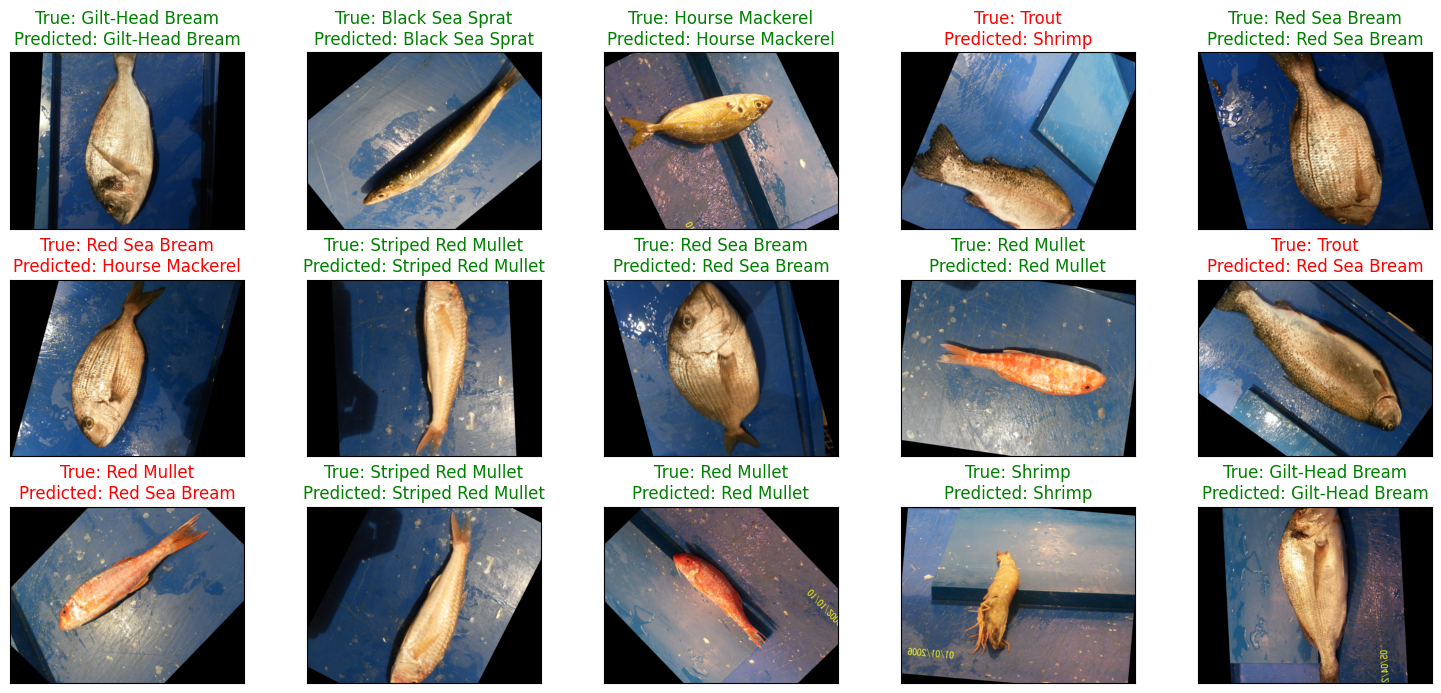

In [104]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_images.filepaths[i]))
    if test_images.labels[i] == pred_classes[i]:
        color = 'green'  
    else:
        color = 'red'    
    ax.set_title(f"True: {class_labels[test_images.labels[i]]}\nPredicted: {class_labels[pred_classes[i]]}", color = color)  

plt.tight_layout()
plt.show()